# Overview
This notebook was created to analyse the Airbnb dataset provided by the online data science platform Kaggle. The data can be found through the following [link](https://www.kaggle.com/datasets/mysarahmadbhat/airbnb-listings-reviews?sort=votes).
Acquiring the data might require registering and logging in to the platform

# Preliminary: Imports and loading data
Please make sure to have the dataset saved in the workding directory

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
import os
from zipfile import ZipFile

# please save the data in sample_data folder if the notebook is running on google colab
DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
file_name = "archive.zip"
file_name_no_zip = "archive"
loc = os.path.join(DOWNLOAD_DIR, file_name)
# opening the zip file in READ mode

if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
    with ZipFile(loc, 'r') as zip_ref:
        zip_ref.extractall()
        print('Done!')

Done!


In [5]:
from copy import copy
# the relevant datasets are Listings.csv and Reviews.csv

listings_loc = os.path.join(os.getcwd(), "data",'Listings.csv')
reviews_loc = os.path.join(os.getcwd(), "data",'Reviews.csv')

#retrieve the data
ls = pd.read_csv(listings_loc,  encoding='latin1')
revs = pd.read_csv(reviews_loc, encoding='latin1')

ls_org = copy(ls) # keeping a copy of the original dataset
revs_org = copy(revs) # keeping copy of the original dataset for further use

C:\Users\bouab\AppData\Local\Temp\ipykernel_20216\614642634.py:8: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ls = pd.read_csv(listings_loc,  encoding='latin1')


# Helper functions
In this subsection, I write a number of functions that I will use across the jupyter notebook

In [6]:
def get_col_types(df: pd.DataFrame, nunique_as_discrete=20):
    # select all numerical features 
    num_cols = set(list(df.select_dtypes(np.number).columns))
    # any feature that is non-numerical is selected as categorical
    cat_cols = set([c for c in df.columns if c not in num_cols])
    
    # let's further filter the numerical features: those with a small number of unique values are considered categorical
    discrete_num_cols = [col for col in num_cols if len(df.value_counts(col)) <= nunique_as_discrete]
    # add them to the categorical features
    cat_cols.update(discrete_num_cols)
    # update the numerical features
    num_cols = num_cols.difference(cat_cols)
    return list(num_cols), list(cat_cols)

In [7]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def draw_unique_data_table(df):
    nunique = pd.DataFrame(data=[], columns=['n_unique'])
    for c in df.columns:    
        nunique = pd.concat([nunique, pd.DataFrame({'n_unique': [len(df[c].value_counts())]}, index=[c])])
    return nunique


In [8]:
def map_values(df:pd.DataFrame, columns:list , cols_dicts:dict):
    """ This function will map certain values in each passed to another set of values. The mapping is defined by the cols_dicts
    """
    # first make sure all columns are part of the dataframe
    try:
        df.loc[:, columns] 
    except KeyError:
        print(f"PLEASE MAKE SURE THAT each column in {list(columns)} belongs to the passed dataframe")
    
    # make sure passing a string is acceptable
    if isinstance(columns, str):
        columns = [columns]
    
    # make sure passing a single dictionary is acceptable
    if isinstance(cols_dicts, dict):
        cols_dicts = [cols_dicts]

    # second make sure the lengths of both iterables are the same
    assert len(columns) == len(cols_dicts)

    # map the dictionary and the columns into a single dictionary
    replace_dictionary = dict(zip(columns, cols_dicts))
    # return the new dictionary
    return df.replace(to_replace=replace_dictionary)

In [9]:
def new_col_names(old_new_names, df):
    try:    
        df = df.rename(columns=old_new_names)
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        print(f"PLEASE MAKE SURE THAT each column in {df_no_col} is in the passed dataframe")
    return df

In [10]:
from empiricaldist import Cdf

def display_cdfs(data:pd.DataFrame, y:str, feat:str, feat_values:list=None, title:str=None):
   
    # if the values of the feature are not determined, then we consider all values
    if feat_values is None: 
        feat_values = list(data[feat].value_counts().index)
    
    # construct the conditional cdf of the target 'y' for each unique passed value of 'feat' 
    for v in feat_values:
        d = data[data[feat] == v][y]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=v)

    plt.legend()
    plt.xlabel(f'{y}')
    plt.ylabel(f'cdf of {feat}')
    plt.title((title if title is not None else f'cdf of {y} with respect to {feat}'))
    plt.show()   


In [11]:
def display_histogram(data, num_feat, cat_feat, figsize=None, title:str=None):
    if figsize is None:
        figsize = (10, 10)
    plt.figure(figsize=figsize)
    cat_unique = list(data.value_counts(cat_feat).index)
    for v in cat_unique:
        plt.hist(data[data[cat_feat] == v][num_feat], bins=100, alpha=0.5, label=f"{cat_feat} == {v}")

    plt.xlabel(f"{num_feat}", size=14)
    plt.ylabel("count", size=14)
    plt.title(title if title is not None else f"{num_feat} distribution for different values of {cat_feat}")
    plt.legend(loc='upper right')
    plt.show()

def display_cat_plot(data: pd.DataFrame, num_feat, cat_feat, num_cat='box', title:str=None):
    g = sns.catplot(data=data, x=num_feat, y=cat_feat, kind=num_cat, orient='h')
    g.fig.suptitle(title if title is not None else f"distribution of {num_feat} for different values of {cat_feat}")
    g.set(xlabel=f"{num_feat}", ylabel=f"{cat_feat}")
    plt.show()

def visualize_num_cat(data: pd.DataFrame, num_feat: str, cat_feat: str, num_cat='box', nunique_as_discrete=20, title=None):
        valid_num_cat = ['cdf', 'hist', 'box', 'violin','boxen']
        num_cat = num_cat.lower()
        
        # make sure to have a meaningful plot
        if num_feat == cat_feat or len(data.value_counts(cat_feat)) > nunique_as_discrete: 
            print(f"THE CATEGORICAL FEATURE {cat_feat} HAS TOO MANY CATEGORIES")
            print("PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES")
            return
        try:
            assert num_cat in valid_num_cat
            # only display categorical features with reasonable number of categories / unique values
            if num_cat == 'cdf':
                display_cdfs(data, y=num_feat, feat=cat_feat, title=title)
            elif num_cat == 'hist':
                display_histogram(data, num_feat=num_feat, cat_feat=cat_feat, title=title)
            else:
                display_cat_plot(data=data, num_feat=num_feat, cat_feat=cat_feat, num_cat=num_cat, title=title)
        except (KeyError, AssertionError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID num_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {valid_num_cat}")    

def visualize_cat_cat(data: pd.DataFrame, cat1: str, cat2: str, nunique_as_discrete=20, cat_cat='count', hist_stats='percent'):
        # make sure to have a meaningful plot
        if cat1 == cat2 or len(data.value_counts(cat1)) > nunique_as_discrete or len(data.value_counts(cat2)) > nunique_as_discrete: 
            print(f"THE CATEGORICAL FEATURE {cat1} or {cat2} HAS TOO MANY CATEGORIES")
            print("PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES")            
            return
        
        # the hue parameter should be assigned the feature with the smaller number of possible values
        feats = [cat1, cat2]
        feats = sorted(feats, key=lambda x: len(data.value_counts(x)))
        hue_feat, x_feat = feats
        try:            
            if cat_cat == 'hist':
                sns.histplot(data=data, x=x_feat, hue=hue_feat, stat=hist_stats)
            else:
                sns.catplot(kind=cat_cat, data=data, x=x_feat, hue=hue_feat)                
            plt.xticks(rotation=45)
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['count', 'bar', 'hist']}")    
        
def visualize_num_num(data: pd.DataFrame, num1: str, num2: str, num_num='scatter'):
        # make sure to have a meaningful plot
        if num1 == num2: 
            return
        
        try:
            g = sns.relplot(data=data, x=num1, y=num2, kind=num_num)
            g.fig.suptitle(f"The bivaritate distribution of {num1} and {num2}")
            g.set(xlabel=f"{num1}", ylabel=f"{num2}")
            plt.legend('best')
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['scatter']}")    


In [12]:
def visualize_interaction(data:pd.DataFrame, feature, use_cols=None, nunique_as_discrete=20, num_cat='box', num_num='scatter', cat_cat='count', num_feats=None, cat_feats=None
, hist_stats='percent'):
    try:
        data[feature]
    except (KeyError):
        print(f"{feature} is not part of the dataframe's features")
        return 

    if use_cols is None:
        use_cols = data.columns

    if isinstance(use_cols, str):
        use_cols = [use_cols] 

    # filter the use_cols to keep only those belonging to the passed dataframe
    use_cols = [column for column in use_cols if column in set(data.columns)]

    if num_feats is None or cat_feats is None:
        # extract the numerical and categorical features, if they are not specified by the user-call
        num_feats, cat_feats = get_col_types(data)

    # consider the case where the passed feat is indeed categorical:
    if feature in cat_feats:
        # iterate through all the columns in the dataset
        for col in use_cols:
            if col in num_feats: 
                visualize_num_cat(data=data, num_feat=col, cat_feat=feature, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)
            elif col in cat_feats:
                visualize_cat_cat(data=data, cat1=col, cat2=feature, cat_cat=cat_cat, nunique_as_discrete=nunique_as_discrete, hist_stats=hist_stats)
    
    elif feature in num_feats:
        for col in use_cols:
            if col in num_feats:
                visualize_num_num(data=data, num1=col, num2=feature)
            elif col in cat_feats:
                visualize_num_cat(data=data, num_feat=feature, cat_feat=col, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)    
    

In [13]:
# even though the previous visualization options are quite helpful, sometimes the data analysis purposes require a bit more detailed and statistics-oriented results
# assuming we have a target varaible y and an explantory variable 'x': (categorical)  

def visualize_cond_prob(data: pd.DataFrame, target:str, hue:str, nunique_as_discrete=20):
    try:
        c1 = data[hue] 
        c2 = data[target]    
    except KeyError:
        print(f"PLEASE MAKE SURE BOTH {hue} and {target} ARE COLUMNS OF THE PASSED DATAFRAME")
        return

    if hue == target or len(data[hue].value_counts()) > nunique_as_discrete:
        print("Please make sure to input two different categorical columns")
        return

    # first extract the unique values of each of the passed columns
    target_values = data[target].value_counts().index
    hue_values = data[hue].value_counts().index
    

    # define the resulting dataframe shape
    result = pd.DataFrame(data=[], index=target_values, columns=hue_values)

    for h in hue_values:
        # the number of rows for which the column hue has the value 'h'
        h_count = len(data[data[hue] == h])
        result[h] = data[data[hue] == h][target].value_counts() / h_count

    # counting for the following possibility: certain combination of value of hue and target do not appear in the result
    result.fillna(value=0, inplace=True)

    # visualize the result by creating a heatmap
    g = sns.heatmap(result, annot=True, linewidth=0.5, linecolor='b', cmap=sns.color_palette("rocket_r", as_cmap=True))
    # let's add labels to the axis
    plt.xlabel(f'values of the column {hue}')
    plt.ylabel(f'conditional probabilities {target} on {hue}')
    plt.title(f'condition distribution of {target} on {hue}')
    plt.show()


In [14]:
def detect_outliers(df, column):
    # first calculate the percentiles
    Q3, Q1 = np.percentile(df[df[column].notnull()][column], [75 ,25]) # find the quantiles for non-nan values
    iqr = Q3 - Q1
    lower = Q1 - iqr * 1.5
    upper = Q3 + iqr * 1.5
    return lower, upper    

# Data Description

In [15]:
# let's see what our ls datasets have for us
ls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   279712 non-null  int64  
 1   name                         279539 non-null  object 
 2   host_id                      279712 non-null  int64  
 3   host_since                   279547 non-null  object 
 4   host_location                278872 non-null  object 
 5   host_response_time           150930 non-null  object 
 6   host_response_rate           150930 non-null  float64
 7   host_acceptance_rate         166625 non-null  float64
 8   host_is_superhost            279547 non-null  object 
 9   host_total_listings_count    279547 non-null  float64
 10  host_has_profile_pic         279547 non-null  object 
 11  host_identity_verified       279547 non-null  object 
 12  neighbourhood                279712 non-null  object 
 13 

In [16]:
# let's procceed by removing duplicates, each listing has its own id. Nevertheless, a listing will be considered dupliacted if it has the same features (except the name and the id)
ls = ls.drop_duplicates(subset=list(ls.columns[2:]))
print(len(ls))
# we don't have too many duplicates

# let's rename the columns

new_cols = {"host_response_time": "res_time", "host_acceptance_rate": "acceptance_rate", 'host_response_rate': 'res_rate',
"host_is_superhost":"superhost", "host_total_listings_count": "ls_count", "host_has_profile_pic": "pf", "host_identity_verified": "identity"}

ls = new_col_names(new_cols, ls)

host_dict = {"t": 1, "f": 0}
ls = map_values(ls, columns=['superhost', 'pf', 'identity'], cols_dicts= [host_dict] * 3)

279595


In [17]:
draw_unique_data_table(ls)

,n_unique
listing_id,279595
name,265776
host_id,182024
host_since,4240
host_location,7159
res_time,4
res_rate,91
acceptance_rate,101
superhost,2
ls_count,206


In [18]:
# one intriguing result is the small number of unique values in the reviews' columns: with only 63 review scores: which is extremely low for a float data type
# let's consider the number of nan values
draw_missing_data_table(ls)

,Total,Percent
district,242595,0.867666
res_time,128742,0.460459
res_rate,128742,0.460459
acceptance_rate,113052,0.404342
review_scores_value,91689,0.327935
review_scores_location,91679,0.327899
review_scores_checkin,91675,0.327885
review_scores_accuracy,91617,0.327678
review_scores_communication,91591,0.327585
review_scores_cleanliness,91569,0.327506


The two cells above suggest the following:
1. Dropping the district column as it has more that 86% nan values: the information can be easily extracted from the coordinates
2. Dropping the listing id, listing name, host location (as the host does not need to be on premises to manage the listings)
2. Investigating the reason behind the very low variance in the reviews' columns and deciding whether it is worthy to keep it in the data.

In [19]:
ls.drop(columns=['district', 'listing_id', 'name', 'host_location'], inplace=True)

# Reviews:  The target data
Let's investigate the very low variance of the review scores

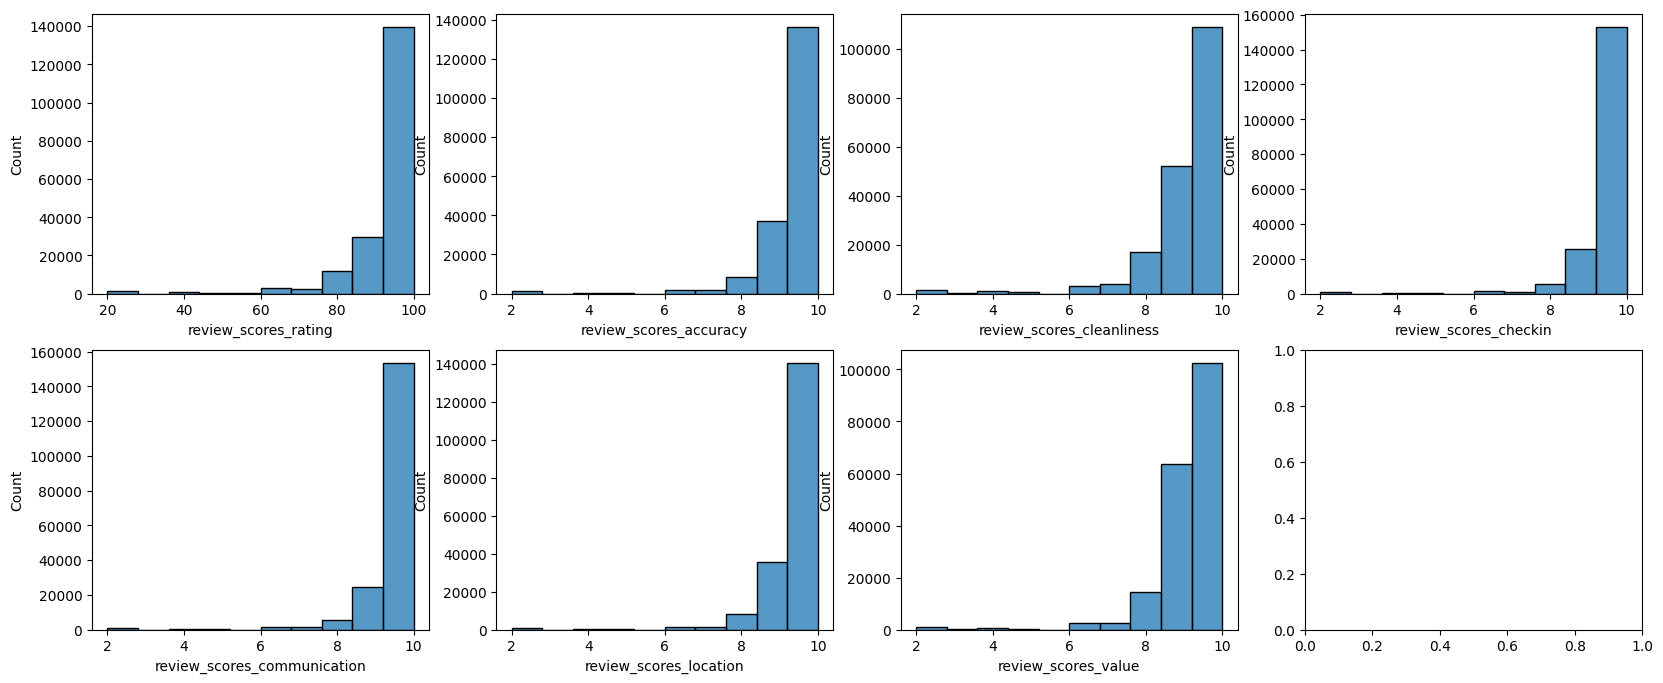

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

REVIEWS = [col for col in ls.columns if 'review' in col.lower()]

figure, axes = plt.subplots(2, 4,figsize=(20, 8), sharex=False, sharey=False)

for i, rv in enumerate(REVIEWS):  
    sns.histplot(ax=axes[i // 4, i % 4], data=ls, x=rv, bins=10)

plt.show()

The box plots above perfecty indicate the indeniable inflation of the review scores :The minimum non-outlier value being at least 8 out of 10 (or 80 out of 100) in each of the 7 review scores' categories. The latter proves that reviews cannot reliably reflect the listing or the property's quality.

In the light of the this conclusion, There are two main approaches to be considered:
1. In a perfect world, acquire more data and with higher variance to have a more reliable assessment of the user's experience (maybe actual text data) 
2. Working with the current data, it might be reasonable to convert the current problem into a classification problem. What properties /  listings provide negative 
user-experience (the threshold for positive experience is getting quite high) .

The current dataset is the only one available. Thus, the 2nd approach is the most fruitful.

The 2nd approach itself is not free of issues. We cannot proceed with the converting the problem at hand into a classificaiton without tackling the problem of missing values. The latter can be solved in 2 main ways:  
1. Dropping the missing data
2. Imputing by understanding the relation between the low reviews and the rest of the available features

In [21]:
# the rating has the highest variance. As the rest of the 
# the rating is the review with the highest variance. This one will be used as the main criterial to classify the listings 

RATING_REVIEW = 'review_scores_rating'

Q3, Q1 = np.percentile(ls[ls[RATING_REVIEW].notnull()][RATING_REVIEW], [75 ,25]) # find the quantiles for non-nan values
iqr = Q3 - Q1
THRESHOLD = Q1 - iqr * 1.5
print(Q3, Q1)
print(THRESHOLD)

100.0 91.0
77.5


We can see that the 3-rd percentile of the ratings is the maximum value. It might be more interesting to consider a binary classification problem: which listings are in the lowest quarter 

a first look at the columns shows that the columns can be divided into 4 main categories:
1. host information
2. geographical information (form city all the way to neighborhood and even the exact coordinates)
3. listing description: more detailed objective information about the listing
4. reviews: reviews scores on differents part of the user's experience 

For this analysis, we will use data with no missing values

In [22]:
# let's introduce this new column
def is_negative(row):
    if np.isnan(row[RATING_REVIEW]):
        row['is_negative'] = np.nan
    else:
        row['is_negative'] = row[RATING_REVIEW] < Q1

    return row

# introduce the new feature
ls = ls.apply(is_negative, axis=1)


In [23]:
print(ls['is_negative'].value_counts())

False    144377
True      43909
Name: is_negative, dtype: int64


In [24]:
draw_missing_data_table(ls)

,Total,Percent
res_time,128742,0.460459
res_rate,128742,0.460459
acceptance_rate,113052,0.404342
review_scores_value,91689,0.327935
review_scores_location,91679,0.327899
review_scores_checkin,91675,0.327885
review_scores_accuracy,91617,0.327678
review_scores_communication,91591,0.327585
review_scores_cleanliness,91569,0.327506
is_negative,91309,0.326576


As expected the problem is quite unbalanced. Let's drop the unnecessary columns and proceed to better understand how the data varies

In [25]:
# remove all reviews' scores now
ls.drop(columns=[r for r in REVIEWS if r != RATING_REVIEW], inplace=True)

# too many unique values ??

## categorical columns

In [26]:
df = ls.dropna()
num_cols, cat_cols = get_col_types(df)
draw_unique_data_table(df)

,n_unique
host_id,50344
host_since,4022
res_time,4
res_rate,85
acceptance_rate,101
superhost,2
ls_count,161
pf,2
identity,2
neighbourhood,597


### host_since feature

In [27]:
from datetime import datetime
df['host_since'] = pd.to_datetime(df['host_since'])
today = datetime.today()
datem = datetime(today.year, today.month, 1)
df['now'] = datem
df['exp'] = (df['now'] - df['host_since']).dt.days // 30 # approximate the number of months
# since the data has not being updated in around 2 years, the final values will be the result of subtracting around 24 months
df['exp'] = df['exp'] - 23 

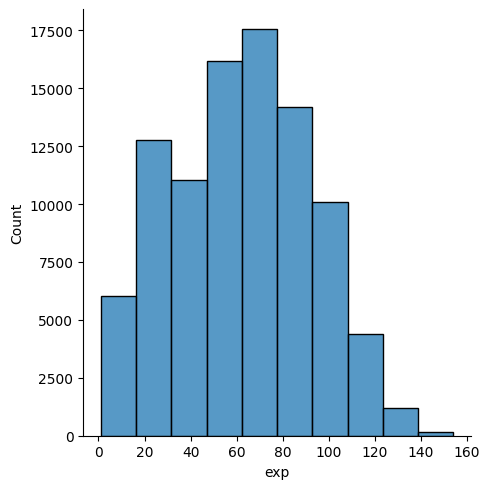

In [28]:
 # let's see how the new feature varies
sns.displot(df, x='exp', bins=10)
plt.show()
# time to set the host_since back
df['host_since'] = df['exp']
df.drop(columns=['exp', 'now'], inplace=True)
# the result is a beautiful bell-shaped distribution  

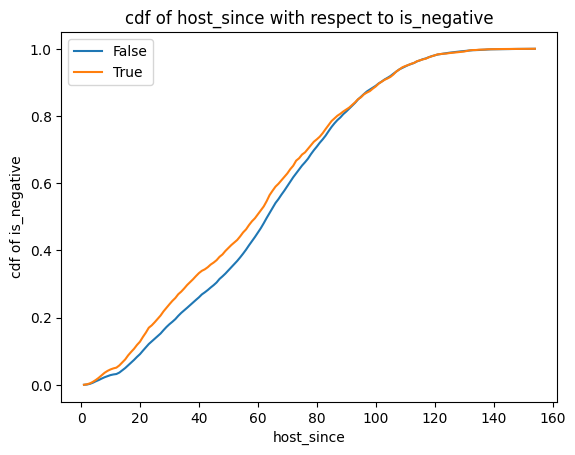

In [29]:
# let's visualize the relation between host_since and the is_negative value
visualize_num_cat(data=df, num_feat='host_since', cat_feat='is_negative', num_cat='cdf')

### The type of the listing
Let's consider the different variables that represent the types of the listing

In [30]:
print(df['room_type'].value_counts())
print(df['property_type'].value_counts())

Entire place    66744
Private room    23244
Hotel room       2417
Shared room      1097
Name: room_type, dtype: int64
Entire apartment             48390
Private room in apartment    11025
Entire house                  5216
Private room in house         4599
Entire condominium            4542
                             ...  
Entire vacation home             1
Yurt                             1
Campsite                         1
Entire in-law                    1
Private room in castle           1
Name: property_type, Length: 106, dtype: int64


We can see that the property type feature introduces additional information as well as complexity. $106$ unique values is quite a large number. Let's try to understand how the target variable varies with respect to the ***room_type*** feature.

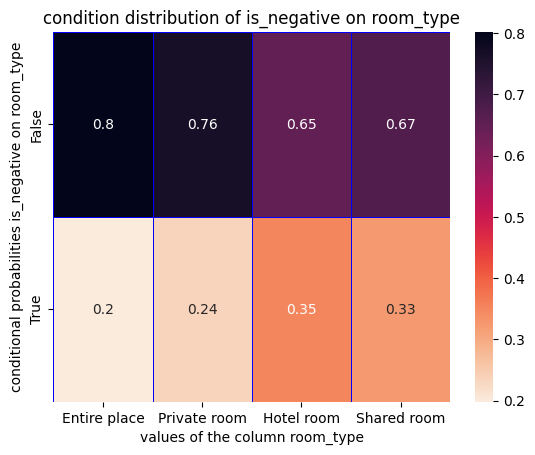

In [31]:
visualize_cond_prob(data=df, target='is_negative', hue='room_type')

The type of the property might not be a determining factor in the review, as the current values are quite close to the generat distribution of the binary classes of the target variable. Nevertheless, the exact number of bedrooms or the number of guests to accommodate is more likely to affect user's review.

### Bedrooms and Guests

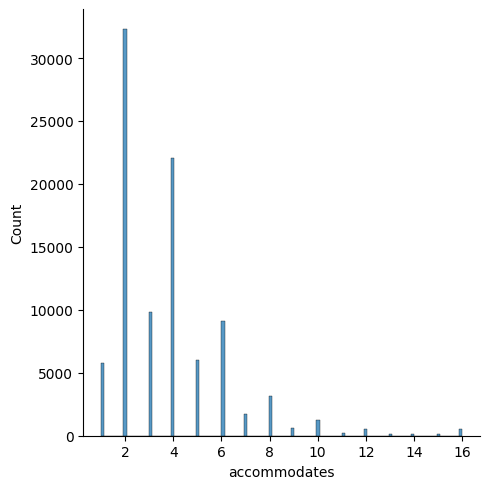

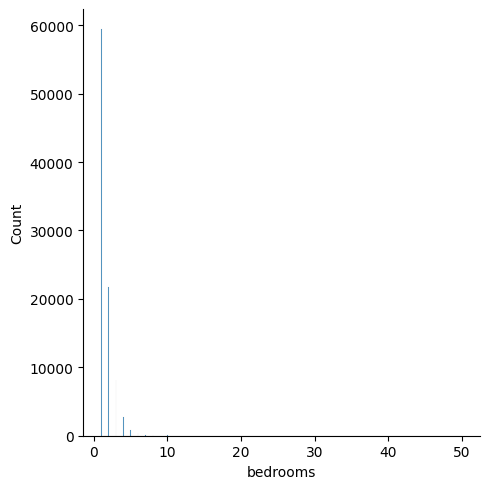

In [32]:
# let's see if the number of guests can be linked to the price.
# first let's display the distribution of the number of guests
sns.displot(data=df, x='accommodates')
sns.displot(data=df, x='bedrooms')
plt.show()

We can see that the actual number of bedrooms is insignificant after 10 bedrooms. Clipping the values seems like quite a good solution for that.

In [33]:
df['is_negative'] = df['is_negative'].astype(int)
# let's clip the number of bedrooms as well as guests
df['bedrooms'] = df['bedrooms'].clip(upper=10)
df['guests'] = df['accommodates'].clip(upper=9)
print(df[['guests', 'bedrooms', 'is_negative']].corr())

               guests  bedrooms  is_negative
guests       1.000000  0.755817     0.002332
bedrooms     0.755817  1.000000    -0.018317
is_negative  0.002332 -0.018317     1.000000


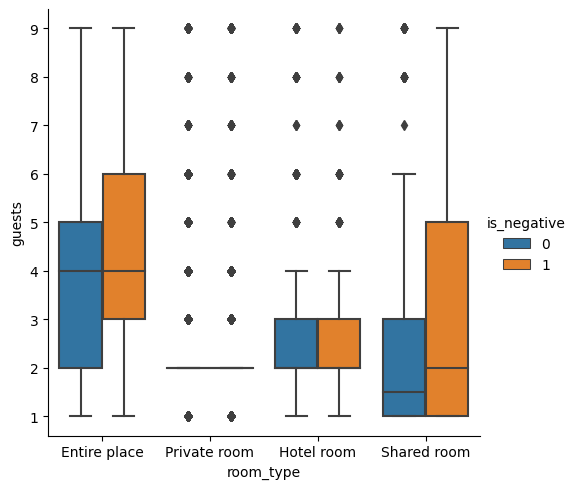

In [34]:
# we can see that a private room generally accomodates 2 people, with some exceptions.
sns.catplot(data=df, y='guests', x='room_type', hue='is_negative', kind='box')

In [35]:
# we can see that the largest variation is in the 'Entire place' column. We can infer the (average) area of the property from the property type feature

from collections import Counter
import re
# a list to save the building blocks
properties = Counter()

for value in df['property_type']:
    # first convert to lower case, remove any training and heading spaces and split the text
    new_val = value.lower().strip()
    # split the
    properties.update(re.split(r'\s+', new_val))

print(properties)

HOUSE_TYPES = set([t for t, v in properties.items() if v >= 2000 and t not in ['entire', 'private', 'in']])

Counter({'entire': 66186, 'apartment': 62563, 'room': 27081, 'in': 27005, 'private': 21279, 'house': 10153, 'condominium': 5677, 'hotel': 3046, 'serviced': 2667, 'loft': 2476, 'boutique': 2085, 'townhouse': 2067, 'guest': 1813, 'suite': 1813, 'bed': 1394, 'and': 1394, 'breakfast': 1394, 'shared': 1097, 'guesthouse': 977, 'hostel': 894, 'villa': 879, 'aparthotel': 579, 'cottage': 358, 'bungalow': 160, 'tiny': 159, 'cabin': 73, 'farm': 49, 'stay': 49, 'place': 47, 'chalet': 31, 'boat': 29, 'earth': 24, 'nature': 19, 'lodge': 19, 'casa': 18, 'particular': 18, 'camper/rv': 17, 'home/apt': 16, 'resort': 14, 'houseboat': 12, 'island': 10, 'treehouse': 6, 'tent': 6, 'barn': 6, 'minsu': 6, 'hut': 5, 'dorm': 5, 'floor': 4, 'castle': 4, 'yurt': 3, 'kezhan': 3, 'dome': 3, 'train': 2, 'campsite': 1, 'in-law': 1, 'vacation': 1, 'home': 1, 'cave': 1, 'bus': 1})


In [36]:
print(HOUSE_TYPES)

{'boutique', 'loft', 'condominium', 'townhouse', 'apartment', 'room', 'hotel', 'serviced', 'house'}


In [37]:
def set_listing_type(row):
    properties = row['property_type'].lower().strip()
    properties = re.split(r'\s', properties) 
    for p in properties:
        if p in HOUSE_TYPES:
            row['listing_type'] = p
            return row
    # set the rest to other
    row['listing_type'] = 'Other'
    return row

df = df.apply(set_listing_type, axis=1)

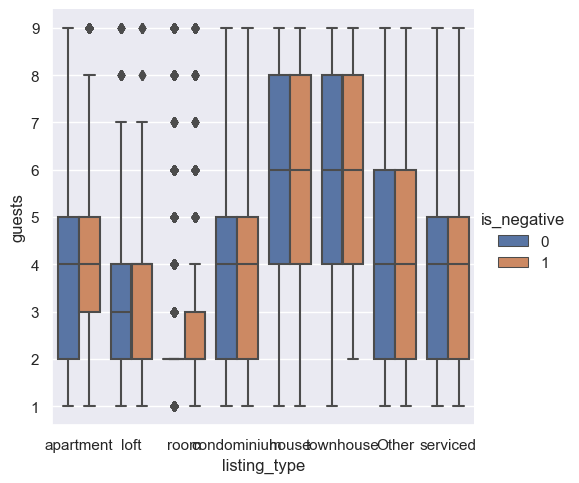

In [61]:
# let's see how the listing_type 

sns.set(rc={"figure.figsize":(5, 5)})
sns.catplot(data=df, y='guests', x='listing_type', hue='is_negative', kind='box')
plt.show()

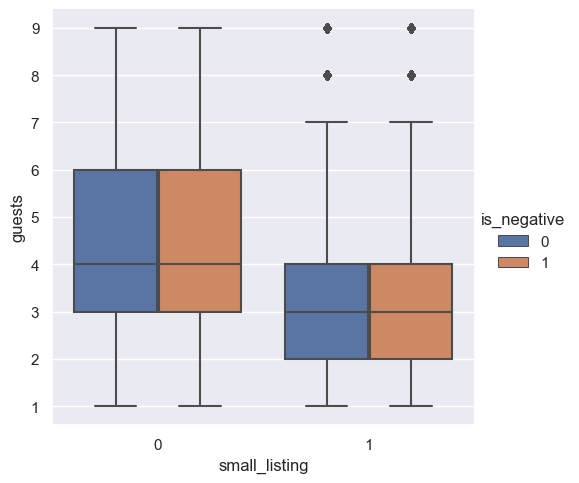

In [39]:
# the number of guests is seemingly significant only for small listings: room, apartment, loft...
# let's verify this hypothesis
df['small_listing'] = df['listing_type'].isin(['apartment', 'loft', 'room']).astype(int)
sns.catplot(data=df, y='guests', x='small_listing', hue='is_negative', kind='box')


THE ANALYSIS ABOVE SHOWS THAT THE TYPE OF THE LISTING HAS LITTLE TO NO INTERACTION WITH THE TARGET VARIABLE

In [40]:
df.drop(columns=['accomodates', 'bedrooms'], inplace=True)

In [41]:
# from collections import Counter
# import re
# # a list to save the building blocks
# properties = Counter()

# for value in df['property_type']:
#     # first convert to lower case, remove any training and heading spaces and split the text
#     new_val = value.lower().strip()
#     # split the
#     properties.update(re.split(r'\s+', new_val))

# print(properties)

# # we as can see the number of different types is quite large, let's understand which aspects really matter: first whether it is an entire property or a partial one
# # partial: 
# in_properties = Counter()
# for v in df['property_type']:
#     new_val = v.lower().strip()
#     if ' in ' in new_val :
#         in_properties.update([new_val]) 

# print(in_properties)

# # let's see the values that do not contain the preposition ' in ' 
# non_in_properties = Counter()
# for v in df['property_type']:
#     v = v.lower().strip()
#     if ' in ' not in v:
#         non_in_properties.update([v])

# print(non_in_properties)


# # let's apply the first approach initially
# # if the term 'private' is not mentioned explicitly, then the listing is assumed to be shared

# def convert_property_type(row):
#     p = row['property_type'].lower().strip()
#     if ' in ' in p:
#         if 'private' in p:
#             row['p_type'] = 'p_room'
#         else:
#             row['p_type'] = 's_room'
#     else: 
#         row['p_type'] = 'entire'

#     return row

# df = df.apply(convert_property_type, axis=1)

### Ameneties

In [42]:
print(df['amenities'].iloc[0])
print(df['amenities'].iloc[1])
print(df['amenities'].iloc[2])

["Pour-over coffee", "Extra pillows and blankets", "Long term stays allowed", "Dishes and silverware", "Heating", "Laundromat nearby", "Iron", "Kitchen", "Essentials", "Hair dryer", "Bed linens", "Hot water", "Hangers", "Microwave", "Cooking basics", "Mini fridge", "Dedicated workspace", "Host greets you"]
["Shampoo", "Dishes and silverware", "Heating", "Iron", "Kitchen", "Hair dryer", "Essentials", "Washer", "Bed linens", "Refrigerator", "Hot water", "Oven", "Wifi", "Cooking basics", "Long term stays allowed", "Dedicated workspace"]
["Elevator", "Dishes and silverware", "Hangers", "Coffee maker", "Carbon monoxide alarm", "Iron", "Dedicated workspace", "Smoke alarm", "Essentials", "Bed linens", "Dishwasher", "Shampoo", "Heating", "Washer", "Kitchen", "Refrigerator", "Hot water", "Oven", "Wifi", "Long term stays allowed", "Microwave"]


In [43]:
import re
from collections import Counter
# let's try to tackle the problem of amenities.
ameneties_counter = Counter()

for a in df['amenities']:
    a = a[1:-1] # the field is a string and not a list
    # let's remove any non-alpha numerical characters
    a = re.sub('[^\w\s,-]', '', a)
    ameneties_counter.update([a.strip() for a in re.split(r',', a.lower())])
    
print(len(ameneties_counter))
print(ameneties_counter)

2048
Counter({'wifi': 89905, 'essentials': 87904, 'long term stays allowed': 84600, 'kitchen': 81362, 'hangers': 79820, 'tv': 76892, 'hot water': 74459, 'hair dryer': 73780, 'iron': 73574, 'dedicated workspace': 69504, 'shampoo': 64934, 'dishes and silverware': 63123, 'refrigerator': 61804, 'washer': 61773, 'heating': 60164, 'cooking basics': 56846, 'air conditioning': 54236, 'smoke alarm': 53571, 'microwave': 52036, 'bed linens': 49034, 'stove': 48505, 'coffee maker': 46117, 'fire extinguisher': 41872, 'oven': 41546, 'elevator': 34906, 'carbon monoxide alarm': 34426, 'first aid kit': 34248, 'dryer': 33052, 'extra pillows and blankets': 32726, 'free street parking': 31634, 'private entrance': 31328, 'luggage dropoff allowed': 30060, 'patio or balcony': 28386, 'free parking on premises': 27848, 'cable tv': 27349, 'host greets you': 22858, 'dishwasher': 22106, 'paid parking off premises': 17711, 'garden or backyard': 16585, 'lock on bedroom door': 15637, 'pool': 14390, 'shower gel': 1329

In [44]:
# let's remove any amenity that does not appear in at least 5% of the listings.
FINAL_AMENITIES = [a for a, freq in ameneties_counter.items() if freq >= 0.05 * len(df)]
print(FINAL_AMENITIES)

['extra pillows and blankets', 'long term stays allowed', 'dishes and silverware', 'heating', 'laundromat nearby', 'iron', 'kitchen', 'essentials', 'hair dryer', 'bed linens', 'hot water', 'hangers', 'microwave', 'cooking basics', 'dedicated workspace', 'host greets you', 'shampoo', 'washer', 'refrigerator', 'oven', 'wifi', 'elevator', 'coffee maker', 'carbon monoxide alarm', 'smoke alarm', 'dishwasher', 'single level home', 'air conditioning', 'free street parking', 'dryer', 'fire extinguisher', 'shower gel', 'tv', 'cable tv', 'first aid kit', 'private entrance', 'pool', 'lockbox', 'gym', 'freezer', 'cleaning before checkout', 'paid parking on premises', 'free parking on premises', 'luggage dropoff allowed', 'bbq grill', 'body soap', 'stove', 'garden or backyard', 'paid parking off premises', 'pack u2019n playtravel crib', 'room-darkening shades', 'indoor fireplace', 'childrenu2019s books and toys', 'breakfast', 'pocket wifi', 'building staff', 'ethernet connection', 'patio or balcony

The next step is to assign a numerical score for the amenity: V1 - V2 where
1. V1 is the average frequency of the amenity in listings with positive reviews
2. V2 is the averge frequency of the amenity in the listings with negative reviews

In [45]:
NEGATVE_AMENTIY_COUNTER = Counter()
POSITIVE_AMENTIY_COUNTER = Counter()

def set_amentities(row):
    # first let's clean the amenities
    a = row['amenities']
    a = a[1:-1]
    a = re.sub('[^\w\s,-]', '', a)
    # only keep the needed amenities
    final_a = [a.strip() for a in re.split(r',', a.lower()) if a.strip() in FINAL_AMENITIES]
    
    # update the frequency of each item in the corresponding counter
    if row['is_negative']:
        NEGATVE_AMENTIY_COUNTER.update(final_a)
    else:
        POSITIVE_AMENTIY_COUNTER.update(final_a)
    
    # set the result to the row value
    row['final_amenities'] = final_a

    return row

# apply this function on each row in the dataframe

In [46]:
df = df.apply(set_amentities, axis=1)

The next step is to estimate the conditional probability:
$$ P(positive | amenity~a) = \frac{P(positive~\&~a)}{P(a)}  = \frac{\frac{count(positive~\&~a)}{count(listings)}}{\frac{count(a)}{count(listings)}} = \frac{count(positive~\&~a)}{count(a)}$$

In [47]:
# after running the cells above, we can estimate the conditional probability: P(positive | amenity a present) for each of the most frequent amenitie

AMENITIES_COND_PROB = Counter()

for a in FINAL_AMENITIES:
    # first extract positive count
    pos_count = POSITIVE_AMENTIY_COUNTER[a]
    # extract the negative count as well to cover the denominator
    neg_count = NEGATVE_AMENTIY_COUNTER[a]
    AMENITIES_COND_PROB.update({a:(pos_count / (pos_count + neg_count))})

In [48]:
# let's how our amenities are doing
print(AMENITIES_COND_PROB)

Counter({'childrenu2019s books and toys': 0.8862870619946092, 'room-darkening shades': 0.8692380056444027, 'body soap': 0.865233350812795, 'garden or backyard': 0.8643955381368706, 'bbq grill': 0.863046357615894, 'patio or balcony': 0.8624674135137039, 'pack u2019n playtravel crib': 0.8622731368258463, 'freezer': 0.8576271186440678, 'dishwasher': 0.8555595765855424, 'single level home': 0.8538664501725187, 'coffee maker': 0.8529392631784375, 'laundromat nearby': 0.8507620660457239, 'extra pillows and blankets': 0.8489885717777914, 'shower gel': 0.8454538617733324, 'free street parking': 0.8453246506922931, 'high chair': 0.8416006669445603, 'oven': 0.840802965387763, 'ethernet connection': 0.839823907890281, 'indoor fireplace': 0.83840190816935, 'pocket wifi': 0.8373922817534657, 'cooking basics': 0.8354677549871583, 'stove': 0.8351716317905371, 'bathtub': 0.8330308529945554, 'host greets you': 0.8305626039023537, 'lockbox': 0.8304114174962558, 'dishes and silverware': 0.830188679245283

In [49]:
# now we have a way to numerically represent the amenities column in our table
def convert_amenities(row):
    # first iterate through the final amenities
    # extract the amenities
    score = sum([np.log(1 + AMENITIES_COND_PROB[a]) for a in row['final_amenities']])
    # score = np.exp(np.mean([AMENITIES_COND_PROB[a]  for a in row['final_amenities']]) if row['final_amenities'] else 0) 
    row['amenities_score'] = score
    return row 
    # let's consider


In [50]:
df= df.apply(convert_amenities, axis=1)

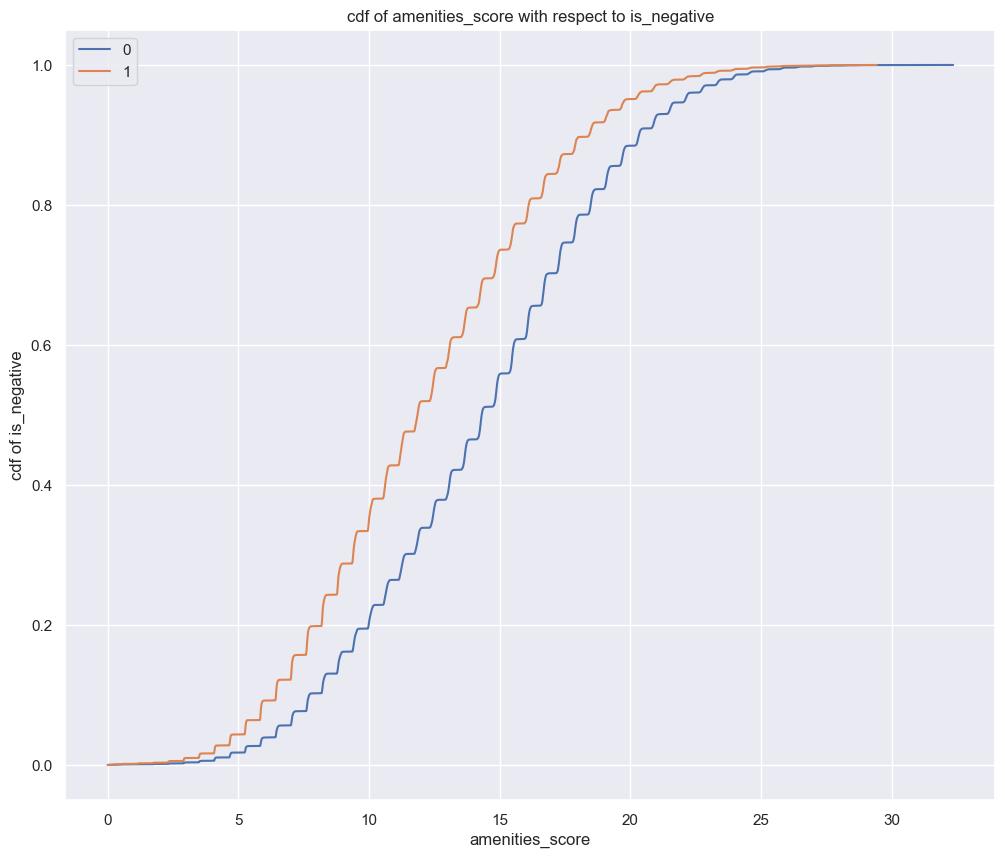

In [51]:
# let's visualize the amenities_score and see if our feature engineering led to any useful insights
visualize_num_cat(data=df, num_feat='amenities_score', cat_feat='is_negative', num_cat='cdf')

In [52]:
stop

NameError: name 'stop' is not defined

## Numerical columns

In [53]:
# let's first the describe method for a general overview
df[num_cols].describe()

,longitude,review_scores_rating,acceptance_rate,price,minimum_nights,maximum_nights,host_id,latitude,ls_count,res_rate,bedrooms
count,93502.000000,93502.000000,93502.000000,93502.000000,93502.000000,9.350200e+04,9.350200e+04,93502.000000,93502.000000,93502.000000,93502.000000
mean,3.808614,93.725311,0.857687,591.892077,5.398612,1.141086e+04,1.037298e+08,15.495157,15.288240,0.909789,1.573624
std,72.699283,9.363979,0.249324,1920.435284,15.860429,3.270314e+06,1.074244e+08,32.189127,76.549161,0.222360,0.971243
min,-99.339630,20.000000,0.000000,9.000000,1.000000,1.000000e+00,1.822000e+03,-34.264400,0.000000,0.000000,1.000000
25%,-43.424237,92.000000,0.830000,88.000000,1.000000,9.000000e+01,1.517687e+07,-22.976577,1.000000,0.960000,1.000000
50%,2.393205,96.000000,0.980000,200.000000,2.000000,1.125000e+03,5.583768e+07,22.295710,3.000000,1.000000,1.000000
75%,28.971970,100.000000,1.000000,586.000000,3.000000,1.125000e+03,1.765595e+08,41.881325,8.000000,1.000000,2.000000
max,151.339230,100.000000,1.000000,163502.000000,1124.000000,1.000000e+09,3.890849e+08,48.901240,7235.000000,1.000000,10.000000


The presence of outliers is quite obvious mainly in the following columns:
1. ls_count (who owns 7k listings ????)
2. price:
3. minimum nights: that's around 3 years 
4. Maximum nights

We can see that the number of maximum nights is completely insignficant after a certain threshold. Such value can be determined by inspecting the amenity: 'long term stays allowed'. Let's dive directly into it.

In [54]:
# let's connect the dots
LONG_TERM_ALLOWED = 'long term stays allowed'
def set_long_term(row):
    row['long_term'] = LONG_TERM_ALLOWED in row['final_amenities'] 
    return row
df = df.apply(set_long_term, axis=1)

In [55]:
# let's see the distribution of the values depending on the new boolean field

print(df[df['long_term'] == True].describe()['maximum_nights'])
print(df[df['long_term'] == False].describe()['maximum_nights'])

count    8.460000e+04
mean     1.259873e+04
std      3.438070e+06
min      2.800000e+01
25%      1.500000e+02
50%      1.125000e+03
75%      1.125000e+03
max      1.000000e+09
Name: maximum_nights, dtype: float64
count    8902.000000
mean      121.985734
std       318.917639
min         1.000000
25%         9.000000
50%        15.000000
75%        21.000000
max      1125.000000
Name: maximum_nights, dtype: float64


The number of maximum nights are not quite informative for the very simple reason that a client would choose to book the listing only if their stay aligns with the indiciated range.

In [56]:
# time to drop the unnecessary columns
df.drop(columns=['maximum_nights', 'minimum_nights', 'long_term'], inplace=True)

## Ls_count: the number of listings owned by the host

In [57]:
lower, upper = detect_outliers(df, 'ls_count')
listings_outliers = df[(df['ls_count'] > upper) | (df['ls_count'] < lower)]['is_negative'].value_counts()


In [62]:
print(listings_outliers[1] / len(df[df['is_negative'] == True]))

0.23307553234230616


WE can SEE THAT almost $\frac{1}{4}$ of the negative experiences are with hosts owning more than $19$ listings. This should be further investigated.

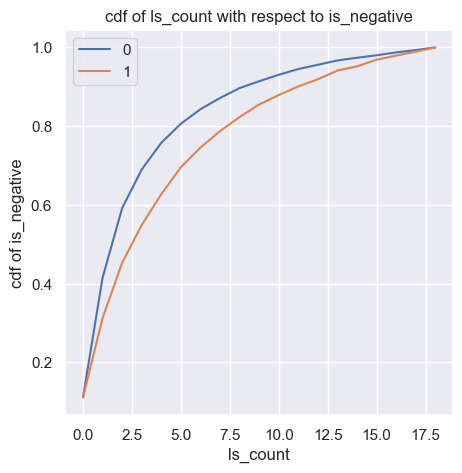

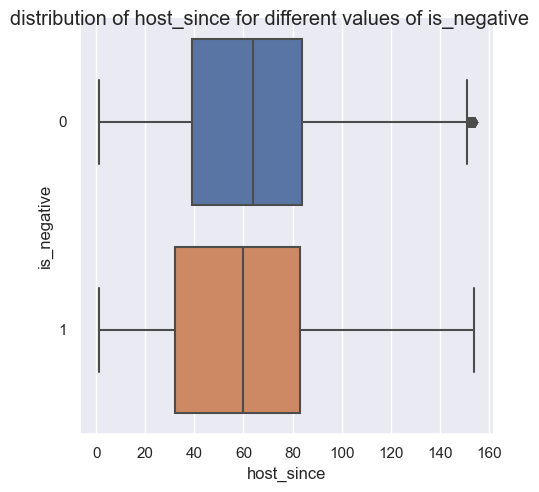

In [64]:
# let's see how number of listings varies in terms of the target variable
visualize_num_cat(data=df[df['ls_count'] <= upper], num_feat='ls_count', cat_feat='is_negative', num_cat='cdf')
visualize_num_cat(data=df, num_feat='host_since', cat_feat='is_negative')

In [ ]:
# lower, upper = detect_outliers(df, 'ls_count')
# print(df[(df['ls_count'] > upper) | (df['ls_count'] < lower)]['is_negative'].value_counts())

# def set_value(row):
#     row['ls_count'] = min(row['ls_count'], 200)
#     return row

# df = df.apply(set_value,axis=1)
# and display the distribution

False    8314
True     4641
Name: is_negative, dtype: int64


### LS count: number of listings
The number of listings might or might not be informative. Generally more listings should reflect more host experience. Nevertheless, more listings require more attention, maintenance and efforts from the host. Can we reflect this observation through combining the different features ? 

In [85]:
df['listing_exp'] = (np.log(1 + df['host_since'])) / (np.sqrt(1 + df['ls_count']))

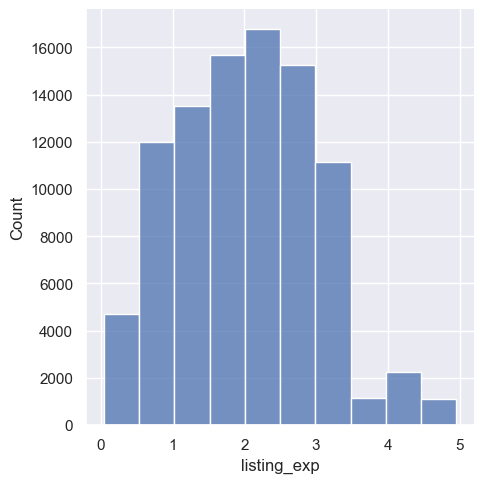

In [86]:
sns.displot(df, x='listing_exp', bins=10)
plt.show()

In [87]:
print(df[['listing_exp', 'is_negative']].corr())

             listing_exp  is_negative
listing_exp     1.000000    -0.185977
is_negative    -0.185977     1.000000


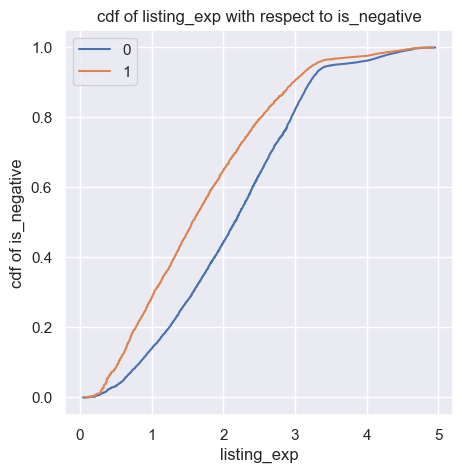

In [88]:
visualize_num_cat(df, num_feat='listing_exp', cat_feat='is_negative', num_cat='cdf')

# Host information 
In the rest of the analysis, we will consider only the data with non-missing values

In [89]:
# first let's define variable for each type of columns
HOST_COLS = ['host_id', 'host_since','res_rate', 
'res_time', 'acceptance_rate', 'superhost', 
'ls_count', 'pf', 'identity']

In [90]:
# for easier and faster manipulation, we will extract the host-related columns and work with sub-dataframe
host_df = df.loc[:, HOST_COLS]
host_df.head()
# let's add the price of the stay to the temporary dataframe
host_df['is_negative'] = df['is_negative'] 

In [91]:
host_df.head()

,host_id,host_since,res_rate,res_time,acceptance_rate,superhost,ls_count,pf,identity,is_negative
26272,153645,131,1.0,within an hour,1.0,0.0,1.0,1.0,1.0,0
26273,305389411,17,1.0,within an hour,1.0,0.0,1.0,1.0,1.0,1
26274,312774780,16,1.0,within an hour,1.0,0.0,1.0,1.0,0.0,1
26275,314090203,16,1.0,within an hour,1.0,0.0,1.0,1.0,0.0,1
26276,308165996,17,1.0,within an hour,1.0,0.0,1.0,1.0,1.0,1


### cleaning and data verification

In [ ]:
# to avoid counting each host more than once, grouping the dataframe on the host_id column is needed
df_verification = pd.pivot_table(df, index='host_id', aggfunc=['min', 'max'], values=host_df.columns[1:])
print(df_verification.head())

                    min                                                \
        acceptance_rate                      host_location host_since   
host_id                                                                 
1822               0.85                 Rome, Lazio, Italy        154   
1944               1.00                 Rome, Lazio, Italy        154   
2353               1.00                 Rome, Lazio, Italy        153   
2571               0.67  Brooklyn, New York, United States        153   
2626               0.83       Paris, Ile-de-France, France        153   

                                                                         \
        identity is_negative ls_count   pf res_rate            res_time   
host_id                                                                   
1822         1.0        True      5.0  1.0     0.50        within a day   
1944         1.0       False     12.0  1.0     1.00      within an hour   
2353         1.0       False      1.0  1

In [ ]:
# let's check the data's consistency
#  the values in in min and max columns should be identical
# let's filter those columns for which there is an inconsistency
def inconsistency(df: pd.DataFrame, col: str):
    return len(df[df[('min', col)] != df[('max', col)]])

# iterating through all the columns and stacking the results will do
inc = None

for c in host_df.columns[1:]:
    # let's evaluate how 
    c_inc = inconsistency(df_verification, c)
    print(f'{round(c_inc / len(df_verification), 3) * 100}% of the rows have different values with the column {c}')
    print()

0.0% of the rows have different values with the column host_since

0.0% of the rows have different values with the column host_location

0.0% of the rows have different values with the column res_rate

0.0% of the rows have different values with the column res_time

0.0% of the rows have different values with the column acceptance_rate

0.0% of the rows have different values with the column superhost

0.0% of the rows have different values with the column ls_count

0.0% of the rows have different values with the column pf

0.0% of the rows have different values with the column identity

9.700000000000001% of the rows have different values with the column is_negative



Our host information is pretty consistent (with very insignificant inconsistencies).  
Now that our data is verified, let's try to understand the hosts' information

In [ ]:
host_num, host_cat = get_col_types(host_df, nunique_as_discrete=15)

In [ ]:
print(host_df.columns)

Index(['host_id', 'host_since', 'host_location', 'res_rate', 'res_time',
       'acceptance_rate', 'superhost', 'ls_count', 'pf', 'identity',
       'is_negative'],
      dtype='object')


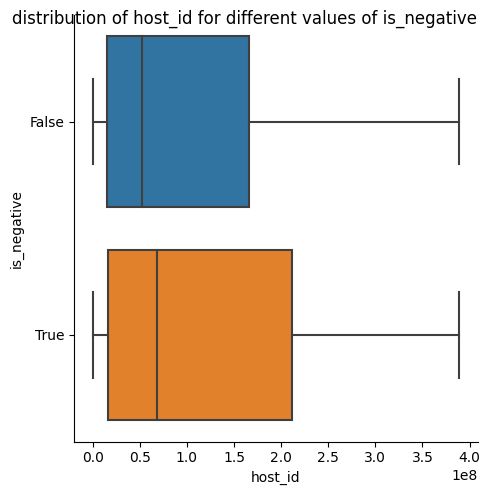

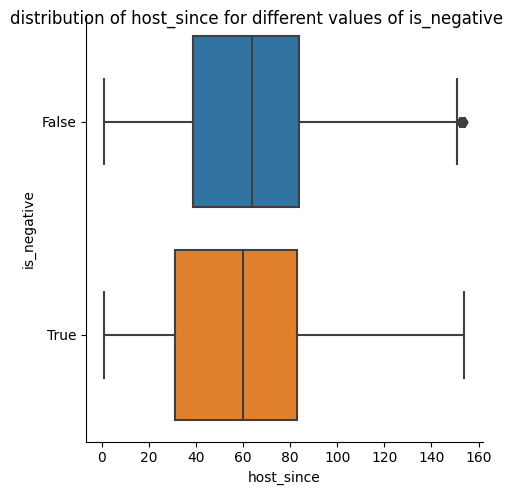

THE CATEGORICAL FEATURE host_location or is_negative HAS TOO MANY CATEGORIES
PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES


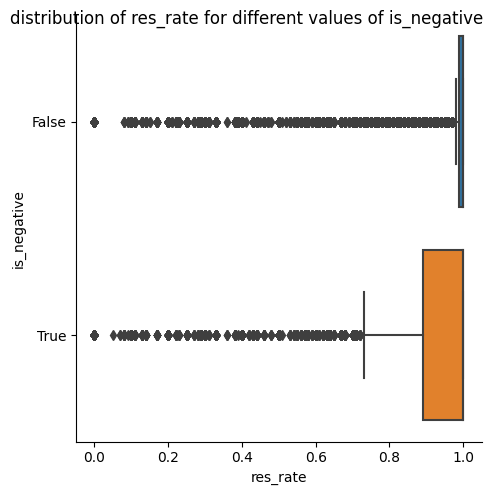

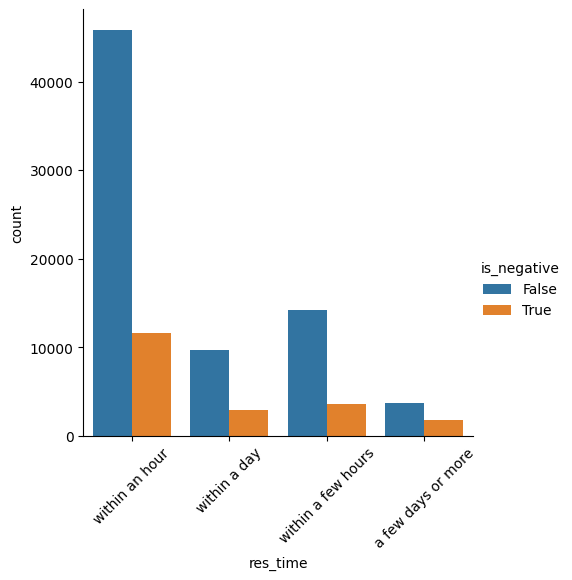

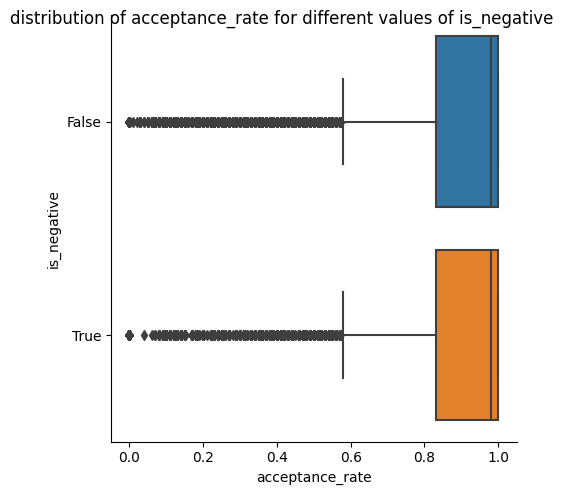

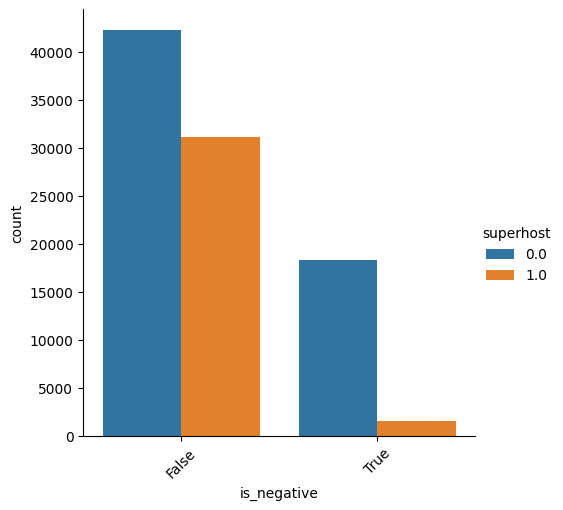

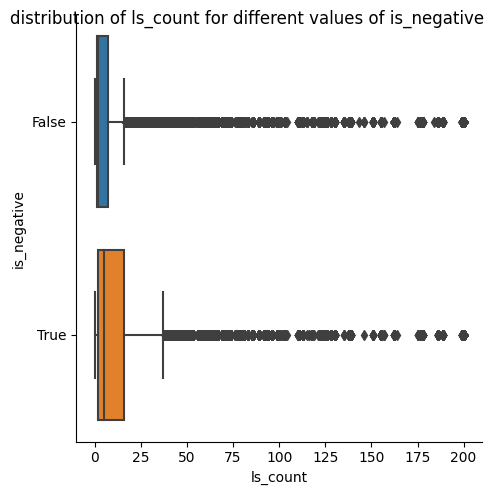

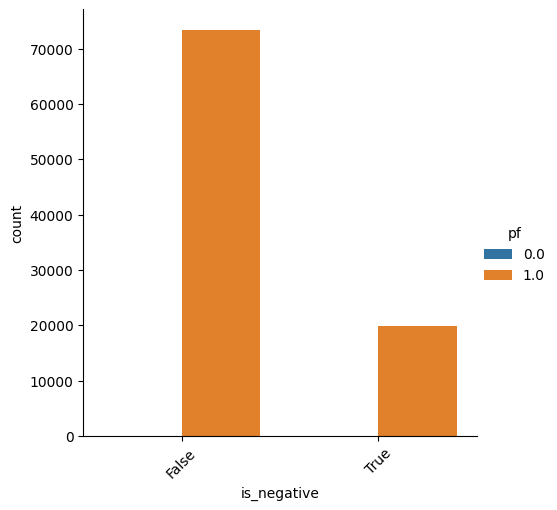

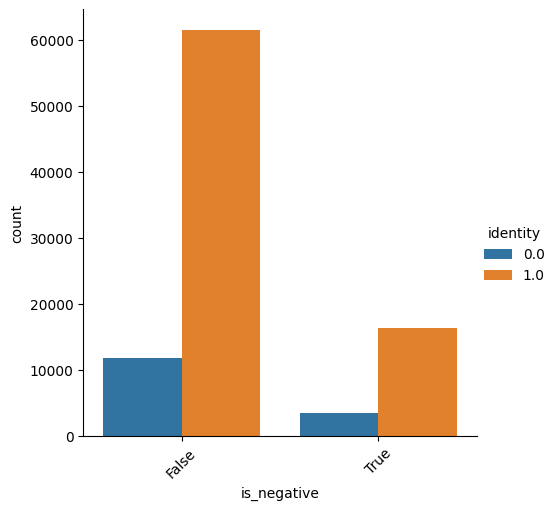

THE CATEGORICAL FEATURE is_negative or is_negative HAS TOO MANY CATEGORIES
PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES


In [ ]:
# let's see how
visualize_interaction(host_df, feature='is_negative', use_cols=list(host_df.columns)) 

The visualizations above are quite intriguing as they lead a number of notable observations:
1. The acceptance rate are of little to no importance in the classification
2. More investigation is needed for the response time and response rate
3. The superhost is indeed a very informative feature. A super host rarely offers a negative user-experience
4. there are suspeciously large values of ls_count
5. The profile picture as well as the identity of the host do not seem to affect the user's experience 
6. The columns host_since and host_location need more investigation

In [ ]:
# drop non-needed columns
df.drop(columns=['res_rate', 'acceptance_rate', 'pf'], inplace=True) 

# Geographical location

## City

In [92]:
# even though specifics generally do not hurt, they may distract us from the big picture, the exact coordinates are not needed (at least at this stage)
df.drop(columns=['longitude','latitude'], inplace=True)

Please make sure to input two different categorical columns


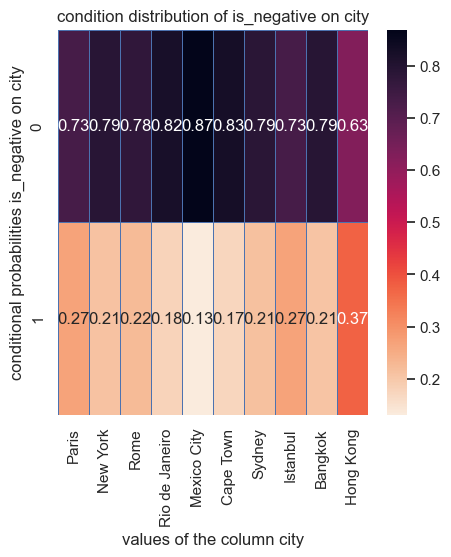

In [93]:
GEO_LOCS = ['neighbourhood', 'city']
# let's consider the conditional probabilities
for g in GEO_LOCS:
    visualize_cond_prob(df, target='is_negative', hue=g)

Apparently the city with the best user-experiences is Mexico City. On other hand one needs to be a bit more careful when booking a listing in Honk Kong.

## Price

In [94]:
# since the price is expressed in the local currency, it is quite important to express the price in terms of its quantile with respect to all the prices in that country
from empiricaldist import Cdf


def produce_cdfs(df: pd.DataFrame, hue_column: str, target_column: str):
    # the column should represent discrete values too
    counter = Counter()
    for value in df[hue_column].value_counts().index:
        counter[value] = Cdf.from_seq(df[df[hue_column] == value][target_column].tolist())
    return counter

PRICE_BY_CITY_CDFS = produce_cdfs(df, hue_column='city', target_column='price')


In [95]:
def convert_price(row):
    # extract the corresponding cfd
    cdf = PRICE_BY_CITY_CDFS[row['city']]
    row['price_relative'] = round(cdf.forward(row['price']) * 100, 2) # convert the probability to percentage
    return row

df = df.apply(convert_price, axis=1)

In [98]:
# let's consider the linear correlation between the price and the target variable
df[['price', 'price_relative', 'is_negative']].corr()
# the idea introduced some improvement, but not a significant one.

,price,price_relative,is_negative
price,1.000000,0.263921,-0.034159
price_relative,0.263921,1.000000,-0.076671
is_negative,-0.034159,-0.076671,1.000000


In [ ]:
# it seems that the relative place alone is not very informative, let's explore how it varies from one country (city) to another
for city in df['city'].value_counts().index:
    city_data = df[df['city'] == city]
    visualize_num_cat(data=city_data, num_feat='price_relative', cat_feat='is_negative', num_cat='cdf', title=f'cdf of price_relative for city = {city}')

The price is most influential in **HONG KONG**. Nevertheless, It is of relatively limited effect: it has almost no interaction with the dependent variable in the case of **RIO DE JANEIRO**

## City and Neighbourhodd

In [109]:
N = 'neighbourhood' 
# let's display the number of unique neighborhoods in each city
pd.pivot_table(data=df, index='city', values=N, aggfunc=lambda x: len(x.value_counts()))

,neighbourhood
city,
Bangkok,47
Cape Town,70
Hong Kong,18
Istanbul,39
Mexico City,16
New York,215
Paris,20
Rio de Janeiro,119
Rome,15


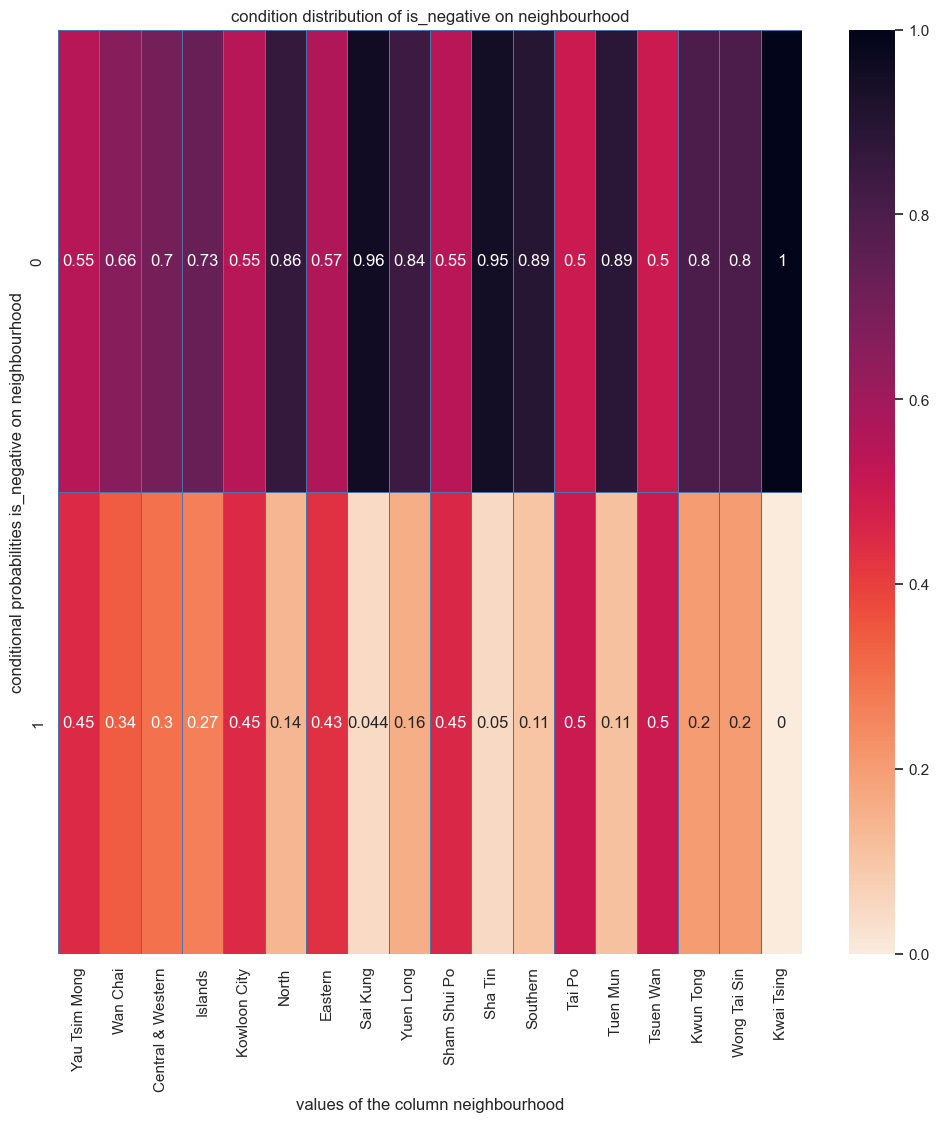

In [118]:
# let's have a random sample of neighbourhoods and see if we can apply some feature enginnering
sns.set(rc={"figure.figsize":(12, 12)})
visualize_cond_prob(df[df['city'] == 'Hong Kong'], target='is_negative', hue=N)

In [119]:
# it seems that the neighborhood information is quite valuable
# create a dictionary to map each value

n_counter = Counter()
for city in df['city'].value_counts().index:
    df_city =  df[df['city'] == city]
    # iterate through each neighbourhood in this temporary dataframe
    for n in df_city[N].value_counts().index:
        total = len(df_city[df_city[N] == n])
        neg = len(df_city[(df_city[N] == n) & (df_city['is_negative'] == True)])
        n_counter.update({n: 1 - (neg / total)})

def set_N(row):
    row['N'] = n_counter[row[N]]
    return row

df = df.apply(set_N, axis=1)

In [128]:
# let's convert the cities to numerical representations
city_counter = Counter()
for city in df['city'].value_counts().index:
    city_num = len(df[df['city'] == city])
    nen_city = len(df[(df['city'] == city) & (df['is_negative'] == 1)])
    city_counter.update({city: 1 - (nen_city / city_num)})

def set_city(row):
    row['city_num'] = city_counter[row['city']]
    return row
df = df.apply(set_city, axis=1)

In [130]:
print(df[['N', 'is_negative', 'city_num']].corr())

                    N  is_negative  city_num
N            1.000000    -0.183003  0.656403
is_negative -0.183003     1.000000 -0.120123
city_num     0.656403    -0.120123  1.000000


THE EXACT NEIGHBOURHOOD PROVIDES RELATIVELY MORE INFORMATION THAN THE CITY IN GENERAL. (THE NUMERICAL REPRESENTATION STILL NEEDS TO BE IMPROVED HOWEVER).

Index(['host_since', 'res_time', 'res_rate', 'acceptance_rate', 'superhost',
       'ls_count', 'pf', 'identity', 'accommodates', 'bedrooms',
       'instant_bookable', 'is_negative', 'guests', 'amenities_score',
       'listing_exp', 'price_relative', 'N', 'city_num'],
      dtype='object')

In [136]:
# drop the unused features
df.drop(columns=[N, 'host_id', 'listing_type', 'room_type', 'property_type', 'final_amenities', 'amenities', 'city', 'small_listing', 'price', 'review_scores_rating'], inplace=True)

In [159]:
res_times = df['res_time'].value_counts().index.tolist()
res_times
# let's convert the numbers 
res_times_counter = Counter()

for r in res_times:
    res_times_counter.update({r:len(df[df['res_time'] == r]) / len(df)})

res_times_freqs = list(res_times_counter.values())

freqs = list(np.cumsum(res_times_freqs))
freqs.insert(0, 0)
for r_t, f in zip(res_times, freqs[:-1]):
    res_times_counter[r_t] = round(f, 2)

In [162]:
def set_res_time(row):
    row['res_time'] = res_times_counter[row['res_time']]
    return row
df = df.apply(set_res_time, axis=1)

In [166]:
df.head()

,host_since,res_time,res_rate,acceptance_rate,superhost,ls_count,pf,identity,accommodates,bedrooms,instant_bookable,is_negative,guests,amenities_score,listing_exp,price_relative,N,city_num
26272,131,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,1.0,0,0,2,9.524967,3.452662,9.06,0.778378,0.732375
26273,17,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,1.0,1,1,2,9.471391,2.043801,44.10,0.778378,0.732375
26274,16,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4,1.0,0,1,4,12.460435,2.003384,50.99,0.723179,0.732375
26275,16,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2,1.0,0,1,2,11.285920,2.003384,32.87,0.778378,0.732375
26276,17,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,1.0,0,1,2,15.469648,2.043801,67.20,0.769231,0.789766


OUR DATA IS NOW READY FOR MODELING.